# A/B testing for adding an extra step to a free trial registration

[mahshidxyz](http://www.github.com/mahshidxyz)

July 2020

This is my solution for the Udacity A/B testing course final project ([link](https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=false)) 

---




## Experiment Overview

At the time of this experiment, Udacity courses had two options on the course overview page: "start free trial", and "access course materials". If the student clicks "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first. If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.

**Hypothesis:** In the experiment, Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead.

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time without significantly reducing the number of students to continue past the free trial and eventually complete the course. If this hypothesis held true, Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course.

**Unit of diversion:** The unit of diversion is a cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward. The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.



## Experiment Design

### Selection of Invariant Metrics
We use invariant metrics for sanity check. We expect the invariant metrics not to differ drastically between the control and experiment groups otherwise the randomization process was not done properly. Here are the invariant metrics that I have selected for this problem from the metrics pool:

- **Number of cookies** - That is, number of unique cookies to view the course overview page.
- **Number of clicks** - That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger).
- **Click-through-probability** - That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page.


### Selection of Evaluation Metrics
These are the metrics that we study to observe a change in. Each evaluation metric has an associated absolute $d_{min}$ value (here given by Udacity) which indicates the practical significant change. Changes smaller than $d_{min}$ are not significant for the business. These are the evaluation metrics that I have selected from the metrics pool:
- **Gross conversion** - That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. ($d_{min}$= 0.01)
- **Retention** - That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. ($d_{min}$=0.01)
- **Net conversion** - That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. ($d_{min}$= 0.0075)

### Baseline Values of Metrics and Variability

Udacity provided the following estimates for these metrics [here](https://docs.google.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0), presumably calculated from aggregated data on daily traffic on a monitoring campaign. I have scaled the values for 5000 cookies visiting the course overview page per day as requested to calculate the standard deviation.

| Item | Description | Estimated (baseline) | Scaled for 5000 daily cookies 
| :- | :- | :- |
| Number of cookies | Daily unique cookies to view course overview page | 40,000 | 5,000 |
| Number of clicks | Daily unique cookies to click Free Trial button | 3,200 | 400 |
| Number of enrollments | Free Trial enrollments per day | 660 | 82.5 |
| CTP |	CTP on Free Trial button | 0.08 | 0.08 |
| Gross Conversion | Probability of enrolling, given a click | 0.20625 | 0.20625 |
| Retention | Probability of payment, given enrollment | 0.53 | 0.53 |
| Net Conversion | Probability of payment, given click | 0.109313 | 0.109313 |


#### Estimating Standard Deviation for Evaluation Metrics for a sample size of 5000 

Assuming our evaluation metrics are probabilities that are binomially distributed, we can analytically estimate the standard deviation using the binomial standard deviation:

\begin{equation*} SD = \sqrt{\frac{p(1-p)}{n}} \end{equation*}

Where $p$ is the probability and $n$ is the sample size. When the unit of diversion in the experiment is not equal to the unit of analysis (the denominator of the metric formula), variance might be different and we need to estimate it empirically. Here unit of diversions and the denominator are cookies for Gross Conversion and Net Conversion; therefore, analytical estimation is good. However, for the Retention metric the denominator of the metric (unit of analysis) is enrolled users while the unit of diversion is cookie. Therefore, if the data was provided it would be best to calculate the variability of the retention metric empirically.



In [1]:
# standard deviation of the evaluation metrics for a sample size of 5000

import math

def std_binomial(p, n):
    return math.sqrt((p * (1 - p))/n)

print ('Analytical std for Gross Conversion (n= 5,000): {}'.format(std_binomial(0.20625, 400)))
print ('Analytical std for Retention (n=5,000): {}'.format(std_binomial(0.53, 82.5)))
print ('Analytical std for Net Conversion (n=5,000): {}'.format(std_binomial(0.109313, 400)))

Analytical std for Gross Conversion (n= 5,000): 0.020230604137049392
Analytical std for Retention (n=5,000): 0.05494901217850908
Analytical std for Net Conversion (n=5,000): 0.015601575884425905


## Experiment Sizing

### Choosing Number of Samples given Power

Given statistical power ($1 - \beta$), significance level ($\alpha$), the detectable effect d ($H_0$ : $p_{cont}-p_{exp}=0$ and $H_A$ : $p_{cont}-p_{exp}=d$), and baseline conversion rate $p$, the minimum number of samples needed for an experiment can be calculated as follows:

\begin{equation*}
n = \frac{(Z_{1-\frac{\alpha}{2}}sd_1 + Z_{1 - \beta} sd_2)^2}{d^2}
\end{equation*}

Where:

$sd_1 = \sqrt{p(1 - p) + p(1 - p)}$ and $sd_2 = \sqrt{p(1 - p) + (p + d)(1 - (p + d))}$

 
The standard deviations can be calculated analytically using binomial distribution formula and the Z score can be read from normal distribution using $1 - \frac{\alpha}{2}$ and for $1 - \beta$. Alternatively, an online [calculator](http://www.evanmiller.org/ab-testing/sample-size.html) can be used to calculate the sample sizes. 

Note that these calculations are based on the assumption that probabilities follow binomial distribution and binomial distribution is approximated with a normal distribution for a large n.

After calculating the required sample size, using the click per pageview or enrollment per page view, the required pageviews have been calculated. If we were to keep all the three metrics, 4,737,818 pageviews, is the minimum number of pageviews needed for this experiment. However, given the daily traffic of 40,000 pageviews, it would take approximately 119 days to complete the experiment at 100% traffic which is not reasonable. Therefore, I will drop the Retention metric. 

In [2]:
# helper functions and sample size calculations:
from scipy.stats import norm

def get_z_score(alpha):
    return norm.ppf(alpha)

def get_sds(p,d):
    ''' returns two standard deviations for null and alternative hypothesis distributions'''
    sd1=math.sqrt(2*p*(1-p))
    sd2=math.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

def get_sample_size(sds,alpha,beta,d):
    n=(get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1])**2/d**2
    return n

print ('Sample size per variation for Gross Conversion metric: {}'
       .format(int(round(get_sample_size(get_sds(0.20625,0.01),0.05,0.2,0.01)))))
print ('Sample size per variation for Retention metric: {}'
       .format(int(round(get_sample_size(get_sds(0.53,0.01),0.05,0.2,0.01)))))
print ('Sample size per variation for Net Conversion metric: {}'
       .format(int(round(get_sample_size(get_sds(0.109313,0.0075),0.05,0.2,0.0075)))))

Sample size per variation for Gross Conversion metric: 25835
Sample size per variation for Retention metric: 39087
Sample size per variation for Net Conversion metric: 27413


|  Metric | Gross Conversion | Retention | Net Conversion |
| :- | :- | :- | :- |  
| Baseline | 0.20625 | 0.53 | 0.109313 |
| $d_{min}$  | 0.01 | 0.01 | 0.0075 |
| Sample size per variation | 25,835 | 39,087 | 27,413 |
| Total sample size | 2x25,835 = 51,670 | 2x39,087 = 78,174 | 2x25,835 = 54,826 |
| Clicks/enrollments/clicks per pageview  | 3,200/40,000 = 0.08 | 660/40,000 = 0.0165 | 3,200/40,000 = 0.08 |
| **Required Pageviews** | **645,875** | **4,737,818** | **685,325** |

### Duration vs. Exposure

Assuming there were no other experiments that we want to run simultaneously, we can divert 100% of the daily traffic to this test (50% control and 50% experiment). The change is not risky enough to keep us from applying it to 50% of the traffic.

With 685,325 required page views and 40,000 daily traffic, the duration of the experiment would be 18 days at 100% traffic. I would round up this number to 3 weeks to include the possible weekly cycles of conversion.

## Experiment Analysis

### Data cleaning

Let's load the datasets first. The experiment was run for 37 days but since the enrollment and payment data of the last 14 days is missing I will remove those rows from the tables. We end up with the test data for 23 consecutive days which is more than the required 21 days duration calculated in the previous section.

In [3]:
import pandas as pd
control = pd.read_csv("control_data.csv")
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [4]:
control.tail()

,Date,Pageviews,Clicks,Enrollments,Payments
32,"Wed, Nov 12",10134,801,NaN,NaN
33,"Thu, Nov 13",9717,814,NaN,NaN
34,"Fri, Nov 14",9192,735,NaN,NaN
35,"Sat, Nov 15",8630,743,NaN,NaN
36,"Sun, Nov 16",8970,722,NaN,NaN


In [5]:
experiment = pd.read_csv("experiment_data.csv")
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


In [6]:
control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
Date           37 non-null object
Pageviews      37 non-null int64
Clicks         37 non-null int64
Enrollments    23 non-null float64
Payments       23 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.5+ KB


In [7]:
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
Date           37 non-null object
Pageviews      37 non-null int64
Clicks         37 non-null int64
Enrollments    23 non-null float64
Payments       23 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.5+ KB


In [8]:
# dropping the rows with null value
control.dropna(inplace=True)
experiment.dropna(inplace=True)

In [9]:
#cleaned data
control

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
5,"Thu, Oct 16",9670,823,138.0,82.0
6,"Fri, Oct 17",9008,748,146.0,76.0
7,"Sat, Oct 18",7434,632,110.0,70.0
8,"Sun, Oct 19",8459,691,131.0,60.0
9,"Mon, Oct 20",10667,861,165.0,97.0


### Sanity Checks

For sanity checks first I will look at the daily flactuations over the duration of test to make sure there are no anomalies. Then, I will look at our selected invariant metrics: number of cookies, number of clicks, CTP. 

#### Daily variations
The trends seems to be reasonable without any large spike over the course of the test.

In [10]:
import matplotlib.pyplot as plt
_ = control.plot()
_ = plt.title('Daily variations in the contorl group over the duration of the experiment')
_ = plt.xlabel('Day')
_ = plt.ylabel('Counts')

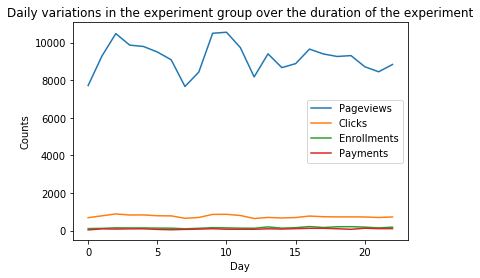

In [11]:
_ = experiment.plot()
_ = plt.title('Daily variations in the experiment group over the duration of the experiment')
_ = plt.xlabel('Day')
_ = plt.ylabel('Counts')

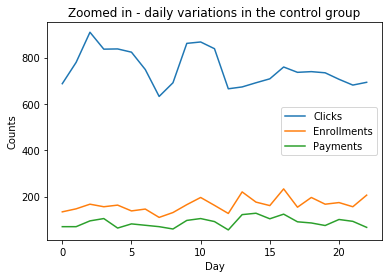

In [12]:
_ = control[['Clicks', 'Enrollments', 'Payments']].plot()
_ = plt.title('Zoomed in - daily variations in the control group')
_ = plt.xlabel('Day')
_ = plt.ylabel('Counts')

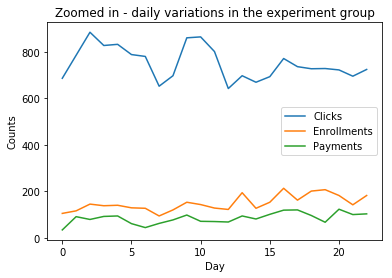

In [13]:
_ = experiment[['Clicks', 'Enrollments', 'Payments']].plot()
_ = plt.title('Zoomed in - daily variations in the experiment group')
_ = plt.xlabel('Day')
_ = plt.ylabel('Counts')

#### Invariant metrics

##### Number of cookies
For an unbiased experiment we expect the difference in the number of cookies for each group to be insignificant.

In [14]:
control_pageviews = control['Pageviews'].sum()
print ("Pageview count for control group: {}".format(control_pageviews))

experiment_pageviews = experiment['Pageviews'].sum()
print ("Pageview count for experiment group: {}".format(experiment_pageviews))

Pageview count for control group: 212163
Pageview count for experiment group: 211362


The numbers seem close, but to formally investigate significance, let's use a binomial random variable where success/failure are defined as experiment/control group. The binomial random variable will give us the number of successes we can expect out of N experiments given the probability of a single success (= 50% for random assignment). We can approximate the binomial distribution by the normal distribution when n is large and $np>5$ and $n(1-p)>5$. What we want to test is whether our observed $\hat{p}$ (number of samples in experiment group divided by total number of samples in both groups) is not significantly different than $p=0.5$ at a 95% confidence level. As long as $\hat{p}$ is within the CI, it is not significantly different than $p=0.5$ and the test passes.


\begin{equation*} X \sim N(p,\sqrt{\frac{p(1-p)}{N}}) \end{equation*}


\begin{equation*} ME = Z_{1-\frac{\alpha}{2}}*SD \end{equation*}

\begin{equation*} CI = [\hat{p} - ME, \hat{p} + ME] \end{equation*}

In [15]:
p = 0.5
total_views = control_pageviews + experiment_pageviews
p_exp = experiment_pageviews / (total_views)
STDEV = std_binomial(p, total_views)

# Calculating the 95% confidence interval
import scipy.stats as st

def conf_interval(p, p_exp, std_dev, alpha):
    z_score = st.norm.ppf(1-(alpha/2))
    upper = p + z_score*STDEV
    lower = p - z_score*STDEV
    print ('experiment probability: {}, expected probability: {}, CI = [{},{}]'.format(p_exp, p, lower, upper))
    if lower <= p_exp <= upper:
        print("Sanity check passed. The number of pageviews are not significantly \
different in the control and experiment groups.")
    else:
        print("The difference in pageviews between the two groups is significant. The experiment is biased!")
    return None

conf_interval(p, p_exp, STDEV, 0.05)

experiment probability: 0.49905436514963697, expected probability: 0.5, CI = [0.4984941608995543,0.5015058391004458]
Sanity check passed. The number of pageviews are not significantly different in the control and experiment groups.


##### Number of clicks
The number of clicks on the free trial button is checked in a similar manner:

In [16]:
control_clicks = control['Clicks'].sum()
print ("Click count for control group: {}".format(control_clicks))

experiment_clicks = experiment['Clicks'].sum()
print ("Click count for experiment group: {}".format(experiment_clicks))

print('')
p = 0.5
total_clicks = control_clicks + experiment_clicks
p_exp = experiment_pageviews / (total_views)
STDEV = std_binomial(p, total_clicks)
conf_interval(p, p_exp, STDEV, 0.05)

Click count for control group: 17293
Click count for experiment group: 17260

experiment probability: 0.49905436514963697, expected probability: 0.5, CI = [0.49472800226164687,0.5052719977383531]
Sanity check passed. The number of pageviews are not significantly different in the control and experiment groups.


##### Click Through Probability

We need to check if the observed CTP for the two groups are similar. This time we need to calculate a confidence interval around an expected difference of zero using a pooled standard deviation.


\begin{equation*} SD_{pool} = \sqrt{\hat{p}_{pool}(1 - \hat{p}_{pool})(\frac{1}{N_{cont}} + \frac{1}{N_{exp}})}
\end{equation*}

Where $\hat{p}_{pool} = \frac{x_{cont} + x_{exp}}{N_{cont} + N_{exp}}$

In [17]:
control_CTP = control_clicks / control_pageviews
print ("CTP of control group: {}".format(control_CTP))

experiment_CTP = experiment_clicks / experiment_pageviews
print ("CTP of experiment group: {}".format(experiment_CTP))

CTP of control group: 0.0815080857642473
CTP of experiment group: 0.08166084726677454


In [18]:
total_CTP = total_clicks / total_views

# Pooled standard deviation:
def stdev_pool(prob_pool, num_samples_control, num_samples_experiment):
    return math.sqrt(prob_pool * (1 - prob_pool) * (1 / num_samples_control + 1 / num_samples_experiment))

STDEV = stdev_pool(total_CTP, control_pageviews, experiment_pageviews)

def conf_interval(p, p_exp, std_dev, alpha):
    z_score = st.norm.ppf(1-(alpha/2))
    upper = p + z_score*STDEV
    lower = p - z_score*STDEV
    print ('observed difference between CTPs: {}, expected difference in CTPs: {}, CI = [{},{}]'.format(p_exp, p, lower, upper))
    if lower <= p_exp <= upper:
        print("Sanity check passed. CTPs are not significantly different in the control and experiment groups.")
    else:
        print("The difference in CTPs between the two groups is significant. The experiment is biased!")
    return None

conf_interval(0, experiment_CTP - control_CTP , STDEV, 0.05)

observed difference between CTPs: 0.0001527615025272433, expected difference in CTPs: 0, CI = [-0.001648778580195615,0.001648778580195615]
Sanity check passed. CTPs are not significantly different in the control and experiment groups.


All of the sanity checks have passed! We can now continue and analyze the results of the experiment.

### Check for Practical and Statistical Significance of the Effect Sizes
We now investigate the size of the differences between the evaluation metrics for the two groups. The two evaluation metrics we chose to move forward with are *Gross Conversion* and *Net Conversion*. In this case, launching the change requires a statistically significant drop in Gross Conversion while Net Conversion does not drop significantly.

#### Gross Conversion
We can conclude the metric is statistically significant if the confidence interval does not include zero. For practical significance, we want the confidence interval to also exclude the practical significance boundary ($d_{min}$ = 0.01).

In [19]:
control_clicks = control['Clicks'].sum()
control_enrollments = control['Enrollments'].sum()
control_gross_conv = control_enrollments / control_clicks
print ("Gross Conversion of control group: {}".format(control_gross_conv))

experiment_clicks = experiment['Clicks'].sum()
experiment_enrollments = experiment['Enrollments'].sum()
experiment_gross_conv = experiment_enrollments / experiment_clicks
print ("Gross Conversion of experiment group: {}".format(experiment_gross_conv))

Gross Conversion of control group: 0.2188746891805933
Gross Conversion of experiment group: 0.19831981460023174


There is a visible difference, let's calculate the confidence interval.

In [20]:
d_min = 0.01
gross_conv_pool = (control_enrollments + experiment_enrollments) / (control_clicks + experiment_clicks)
STDEV = stdev_pool(gross_conv_pool, control_clicks, experiment_clicks)
gross_conv_diff = experiment_gross_conv - control_gross_conv
print("The change in Gross Conversion is: {}%".format(round(gross_conv_diff, 4)))

# Calculating the 95% confidence interval
def conf_interval(prob, std_dev, confidence):
    z_score = st.norm.ppf(1-(confidence/2))
    upper = prob + z_score*STDEV
    lower = prob - z_score*STDEV
    return (lower, upper)
lower, upper = conf_interval(gross_conv_diff, STDEV, 0.05)
print("The 95% confidence interval is: [{}, {}]".format(round(lower, 4), round(upper, 4)))

if lower > 0 or upper < 0:
    print("The change is statistically significant!")
    if (lower > d_min or upper < -d_min):
        print("The change is also practically significant!")
    else:
        print("The change is not practically significant!")
else:
    print("The change is statistically insignificant!")


The change in Gross Conversion is: -0.0206%
The 95% confidence interval is: [-0.0291, -0.012]
The change is statistically significant!
The change is also practically significant!


#### Net Conversion
We will do the same for net conversion.

In [21]:
control_payments = control['Payments'].sum()
control_net_conv = control_payments / control_clicks
print ("Net Conversion of control group: {}".format(control_net_conv))

experiment_payments = experiment['Payments'].sum()
experiment_net_conv = experiment_payments / experiment_clicks
print ("Net Conversion of experiment group: {}".format(experiment_net_conv))

Net Conversion of control group: 0.11756201931417337
Net Conversion of experiment group: 0.1126882966396292


The change looks much smaller in this case. Let's see if it is statistically or practically significant.

In [22]:
d_min = 0.0075
net_conv_pool = (control_payments + experiment_payments) / (control_clicks + experiment_clicks)
STDEV = stdev_pool(net_conv_pool, control_clicks, experiment_clicks)
net_conv_diff = experiment_net_conv - control_net_conv
print("The change in Net Conversion is: {}%".format(round(net_conv_diff, 4)))

# Calculating the 95% confidence interval
lower, upper = conf_interval(net_conv_diff, STDEV, 0.05)
print("The 95% confidence interval is: [{}, {}]".format(round(lower, 4), round(upper, 4)))

if lower > 0 or upper < 0:
    print("The change is statistically significant!")
    if (lower > d_min or upper < -d_min):
        print("The change is also practically significant!")
    else:
        print("The change is not practically significant!")
else:
    print("The change is statistically and practically insignificant!")


The change in Net Conversion is: -0.0049%
The 95% confidence interval is: [-0.0116, 0.0019]
The change is statistically and practically insignificant!


## Summary and Recommendation

This experiment was designed to determine whether encouraging the students with not enough time to skip enrollment and audit the course instead would improve the overall student experience and allow coaches to support students who are likely to complete the course. A statistically and practically signficant decrease in Gross Conversion was observed accompanied with no significant change in Net Conversion. This is actually in line with the test hypothesis which hoped for reducing gross conversion but not significantly reducing the net conversion (number of students who continue past the free trial and may eventually complete the course). Therefore, my recommendation is to launch this experiment.